In [4]:
!pip install fastai==1.0.61 

     |################################| 239 kB 34.7 MB/s eta 0:00:01
     |################################| 88 kB 18.3 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |################################| 115 kB 50.7 MB/s eta 0:00:01
  Created wheel for bottleneck: filename=Bottleneck-1.3.2-cp36-cp36m-linux_x86_64.whl size=330912 sha256=49dd23a2ea3d6bc0a63c82dc8524c38e2a9b1f94758bd614281c3b28bdf7b8c6
  Stored in directory: /root/.cache/pip/wheels/f7/a7/14/9be836efed01ac0eb3c125ac006c143b55ebf689269877d0e8
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=20119 sha256=37a322165089d392eb230c3900b9d5c64998b1e9e36654f0ac82d547c2c7dee2
  Stored in directory: /root/.cache/pip/wheels/7f/26/a3/33f2079871e2bebb3f53a2b21c3ec64129b8efdd18a6263a52
Successfully built bottleneck nvidia-ml-py3
You should consider upgrading via the '/usr/bin/python3 -m pip install --u

In [1]:
%load_ext autoreload
%autoreload 2
from fastai import *
from fastai.text import * 
from fastai.callbacks import *
import pandas as pd
import json
import pathlib
import sklearn
from sklearn import model_selection
import numpy as np
import html

In [2]:
LM_PATH=Path('../../models/ulmfit/lm/tweets-pt-pmann')
DATA_PATH=Path('../../data/twitter-pt/pmann/')
LM_PATH.mkdir(exist_ok=True)

In [3]:
# See how many devices are around
print('Devices available: ', torch.cuda.device_count())
# Set it to a particular device
CUDA_DEVICE = 7
print('Set device: ', CUDA_DEVICE)
torch.cuda.set_device(CUDA_DEVICE)
# Check which device you are on
print('Current device: ', torch.cuda.current_device())

Devices available:  8
Set device:  7
Current device:  7


In [4]:
CORPUS_DATASET = os.path.join(DATA_PATH, 'tweets-pt-pmann-reduced-no-emojis.csv')

In [5]:
def read_data(filename):
    data = pd.read_csv(filename, sep="|", names =['text'], header=None, dtype={'text':str} )
    return data

In [6]:
LANG_TEXT = read_data(CORPUS_DATASET).dropna()

In [7]:
LANG_TEXT.head()

,text
0,username certo ... que remédio ... força n iss...
1,essas pessoas acabaram de visualizar seu perfi...
2,"cheguei aqui na ju , pietro dorme igual um anj..."
3,mirai ticket
4,username sem dúvidas


In [8]:
LANG_TEXT['text'].apply(lambda x: len(x.split(" "))).sum()

56877702

In [46]:
(LANG_TEXT.to_csv(f"{DATA_PATH}/tweets-pt-pmann-reduced_no_emojis_ulmfit.csv", columns=["text"], header=None, index=False))

In [47]:
txt_proc = [
    TokenizeProcessor(tokenizer=Tokenizer(lang='pt') ),
    NumericalizeProcessor(min_freq=3, max_vocab=30000 )
]

In [56]:
data_lm = (TextList
           .from_csv(DATA_PATH, 'tweets-pt-pmann-reduced_no_emojis_ulmfit.csv', cols=0, processor=txt_proc)
           #Where are the text? Column 'text' of texts.csv
           .split_by_rand_pct()
           #How to split it? Randomly with the default 20% in valid
           .label_for_lm()
           #Label it for a language model
           .databunch(num_workers=10))
           #Finally we convert to a DataBunch

/usr/local/lib/python3.6/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [57]:
data_lm.save("tweets_pt_pmann_reduced_data_lm")

In [58]:
len(data_lm.train_ds.vocab.itos)

30000

In [59]:
data_lm.show_batch()

idx,text
0,"arraial do cabo xxbos username fua re negro a donde fuiste xxbos mais um ano que começa , a oportunidade de um recomeço , a oportunidade de fazer tudo aquilo que você sonhou no ano que passou . xxbos tchê , não tem nada como família xxbos xxunk : veja agora as imagens aérea que comprova a gigantesca festa dos 0 anos de xxunk politica . url xxbos username aqui"
1,"xxbos username amor da minha vida xxbos status de visita : 0 pessoas viram esse perfil url xxbos a gente desiste direto de coisas que estamos quase xxunk xxbos eu só queria conseguir dormir pra passar essa virada ligada no 0v xxbos to bem hoje não , nem queria ir trabalhar hoje , se eu pudesse nem saia do quarto hoje xxbos trabalha hoje fodeu com todas as vontades de"
2,aguento mais comer peixe xxbos já é hora de folia e frevo ! ! ! url xxbos queria ter a disposição d essa galera que sai corre de manha na praia xxbos xxunk xxrep 5 o xxbos faria muito não nego xxbos assim seria bom se ele me amasse e tal xxbos pergunte-me qualquer coisa url xxbos querooo que chegue logo xxunk com tudo barro vs asfalto xxbos serviço público
3,um mundo só d ele onde ele tem razão e fala com convicção sobre qualquer assunto do mundo . xxbos username epah eu só sei que elas acabam sempre em xxunk xxbos gratidão ! url xxbos username já falei q ia xxbos atualização de acessos no meu perfil url xxbos trabalhar pra pagar a xxunk facial d ele eu xxbos xxwrep 4 username sdds m xxrep 9 o da minha
4,"username url - jen ai xxunk xxunk remastered xxbos nem queria ter xxunk o vinicius ontem , to muito de cara com ele agr xxbos mano , eu namoro , vai se fude , não é pq eu te trato com educação que vem tem que ver por segundas intenções , macho escroto do caralho xxbos username username username realmente , com essa economia agora mg sai da crise ."


In [60]:
len(data_lm.vocab.stoi)

580188

In [61]:
#data_lm = load_data(DATA_PATH, "tweets_pt_pmann_reduced_data_lm")

In [62]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.05, pretrained=False, callback_fns=ShowGraph)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


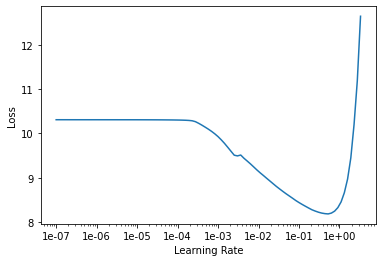

In [63]:
learn.lr_find()
learn.recorder.plot(skip_start=0)

epoch,train_loss,valid_loss,accuracy,time
0,4.205389,4.193559,0.284775,36:58
1,4.203108,4.195656,0.282299,37:27
2,4.164089,4.158756,0.285769,37:01
3,4.122925,4.113709,0.290387,37:14
4,4.072260,4.068268,0.294918,38:52
5,4.016145,4.018474,0.300163,37:20
6,3.949240,3.960105,0.306795,37:42
7,3.881523,3.907667,0.312882,37:43
8,3.800899,3.872871,0.317209,36:49
9,3.734096,3.868227,0.318072,36:28


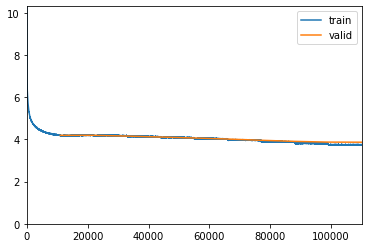

Better model found at epoch 0 with valid_loss value: 4.193559169769287.
Better model found at epoch 2 with valid_loss value: 4.158755779266357.
Better model found at epoch 3 with valid_loss value: 4.113709449768066.
Better model found at epoch 4 with valid_loss value: 4.068268299102783.
Better model found at epoch 5 with valid_loss value: 4.018474102020264.
Better model found at epoch 6 with valid_loss value: 3.9601047039031982.
Better model found at epoch 7 with valid_loss value: 3.907667398452759.
Better model found at epoch 8 with valid_loss value: 3.8728713989257812.
Better model found at epoch 9 with valid_loss value: 3.868227005004883.


In [64]:
learn.fit_one_cycle(10, 1e-2, moms=(0.8,0.7), callbacks=[ShowGraph(learn), SaveModelCallback(learn, name='tweets-pt-30k-pmann-reduced-lm-head-best')])

In [65]:
learn.load("tweets-pt-30k-pmann-reduced-lm-head-best")

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (4260931 items)
x: LMTextList
xxbos essas pessoas acabaram de visualizar seu perfil url,xxbos cheguei aqui na ju , pietro dorme igual um anjinho . nem parece que grita,xxbos mirai ticket,xxbos username sem dúvidas,xxbos username queria achar a xxunk da minha xxunk :
y: LMLabelList
,,,,
Path: ../../data/twitter-pt/pmann;

Valid: LabelList (1065232 items)
x: LMTextList
xxbos username username to no terceirao novas,xxbos ficar brincando muito já vou xxunk com esse carinha,xxbos alguém tira a minha cabeça de mim,xxbos se esse cara não for louco de pó eu não sei quem é,xxbos vou passar a virada de pijama e na cama
y: LMLabelList
,,,,
Path: ../../data/twitter-pt/pmann;

Test: None, model=SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(30000, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(30000, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400,

In [66]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time
0,3.801710,3.896094,0.314616,37:02
1,3.835625,3.901901,0.313755,37:33
2,3.814778,3.881179,0.316164,37:49
3,3.758167,3.860102,0.319235,38:40
4,3.699447,3.858855,0.319699,39:19


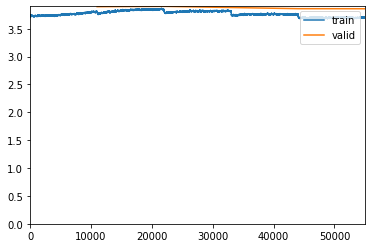

Better model found at epoch 0 with valid_loss value: 3.8960936069488525.
Better model found at epoch 2 with valid_loss value: 3.8811793327331543.
Better model found at epoch 3 with valid_loss value: 3.8601019382476807.
Better model found at epoch 4 with valid_loss value: 3.8588550090789795.


In [67]:
learn.fit_one_cycle(5, 2e-3, moms=(0.8,0.7), callbacks=[ShowGraph(learn), SaveModelCallback(learn, name='tweets-pt-30k-pmann-reduced-lm-step2-best')])

In [68]:
learn.load('tweets-pt-30k-pmann-reduced-lm-step2-best')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (4260931 items)
x: LMTextList
xxbos essas pessoas acabaram de visualizar seu perfil url,xxbos cheguei aqui na ju , pietro dorme igual um anjinho . nem parece que grita,xxbos mirai ticket,xxbos username sem dúvidas,xxbos username queria achar a xxunk da minha xxunk :
y: LMLabelList
,,,,
Path: ../../data/twitter-pt/pmann;

Valid: LabelList (1065232 items)
x: LMTextList
xxbos username username to no terceirao novas,xxbos ficar brincando muito já vou xxunk com esse carinha,xxbos alguém tira a minha cabeça de mim,xxbos se esse cara não for louco de pó eu não sei quem é,xxbos vou passar a virada de pijama e na cama
y: LMLabelList
,,,,
Path: ../../data/twitter-pt/pmann;

Test: None, model=SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(30000, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(30000, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400,

In [73]:
np.exp(3.8588550090789795)

47.411035074239315

In [70]:
learn.save_encoder('tweets_pt_lm_pmann_reduced_30k_encoder')

In [71]:
learn.export('tweets_pt_lm_pmann_reduced_30k_export')

In [72]:
data_lm.vocab.save(pathlib.Path(f"{DATA_PATH}/tweets_pt_lm_pmann_reduced_30k_itos_vocab.pkl"))

In [78]:
!ls ../../models/ulmfit/lm/tweets-pt-pmann/

In [81]:
! mv ../../data/twitter-pt/pmann/tweets_pt_lm_pmann_reduced_30k_* ../../models/ulmfit/lm/tweets-pt-pmann/

In [82]:
!mkdir ../../models/ulmfit/lm/tweets-pt-pmann/models

In [92]:
!mv ../../models/ulmfit/lm/tweets-pt-pmann/tweets_pt_lm_pmann_reduced_30k_* ../../models/ulmfit/lm/tweets-pt-pmann/models/

In [93]:
!ls ../../models/ulmfit/lm/tweets-pt-pmann/models/

tweets_pt_lm_pmann_reduced_30k_encoder.pth
tweets_pt_lm_pmann_reduced_30k_export
tweets_pt_lm_pmann_reduced_30k_itos_vocab.pkl


In [88]:
!rm -rf ../../models/ulmfit/lm/tweets-pt-pmann/models

In [89]:
!mkdir ../../models/ulmfit/lm/tweets-pt-pmann/models/

In [94]:
!ls ../../models/ulmfit/lm/tweets-pt-pmann/

data_lm_virtual_operator  tweets-pt-30k-pmann-reduced-lm-head-best.pth
models			  tweets-pt-30k-pmann-reduced-lm-step2-best.pth
tmp.pth


In [96]:
!mv ../../models/ulmfit/lm/tweets-pt-pmann/tweets-pt* !ls ../../models/ulmfit/lm/tweets-pt-pmann/models/

mv: cannot stat '../../models/ulmfit/lm/tweets-pt-pmann/tweets-pt*': No such file or directory
mv: cannot stat '!ls': No such file or directory


In [97]:
!ls ../../models/ulmfit/lm/tweets-pt-pmann/models/

tweets-pt-30k-pmann-reduced-lm-head-best.pth
tweets-pt-30k-pmann-reduced-lm-step2-best.pth
tweets_pt_lm_pmann_reduced_30k_encoder.pth
tweets_pt_lm_pmann_reduced_30k_export
tweets_pt_lm_pmann_reduced_30k_itos_vocab.pkl
